### 1. Import thư viện 

In [1]:
import pandas as pd
import numpy as np
import joblib
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetBinaryClassifier

### 2. Tải và khám phá dữ liệu 

In [35]:
try:
    df = pd.read_csv('data/spam_ham_dataset.csv')
    print("Tải dữ liệu thành công!")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp 'data/spam_ham_dataset.csv'.")
    print("Hãy chắc chắn rằng bạn đã tạo thư mục 'data' và đặt tệp dữ liệu vào đó.")

df.head()

Tải dữ liệu thành công!


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [36]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [37]:
df['label_num'].value_counts()

label_num
0    3672
1    1499
Name: count, dtype: int64

### 3. Tiền xử lý dữ liệu 

In [38]:
df = df.dropna()

# Làm sạch text
import re

def clean_text(text):
    # Loại bỏ Subject: prefix
    text = re.sub(r'^Subject:\s*', '', text)
    # Loại bỏ email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Loại bỏ URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Loại bỏ khoảng trắng thừa
    text = ' '.join(text.split())
    return text.lower().strip()

# Áp dụng cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Loại bỏ text rỗng
df = df[df['cleaned_text'].str.len() > 0]

In [39]:
# Chọn các cột cần thiết
data = df[['cleaned_text', 'label_num' ]].copy()

print("Dữ liệu sau khi xử lý:")
data.head()

Dữ liệu sau khi xử lý:


,cleaned_text,label_num
0,enron methanol meter this is a follow up to th...,0
1,hpl nom for january see attached file hplnol x...,0
2,neon retreat ho ho ho we re around to that mos...,0
3,photoshop windows office cheap main trending a...,1
4,re indian springs this deal is to book the tec...,0


In [40]:
print("Số lượng spam và ham:")
print(data['label_num'].value_counts())
# Chia dữ liệu thành train và tes

Số lượng spam và ham:
label_num
0    3672
1    1481
Name: count, dtype: int64


### 4. Tạo đặc trưng với SENTENCE TRANSFORMERS

In [41]:
# Sử dụng mô hình `all-MiniLM-L6-v2` đã được huấn luyện trước 
model_name = 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(model_name)

In [42]:
if os.path.exists('data/embedding_spam_ham_datset_cleaned.pkl'):
    print("Tải embeddings từ tệp đã lưu...")
    embeddings = joblib.load('data/embedding_spam_ham_datset_cleaned.pkl')
else:
# Tạo embeddings cho tất cả các tin nhắn
    print("Bắt đầu tạo embeddings cho dữ liệu...")
    corpus = data['cleaned_text'].tolist()

    # Sử dụng tqdm để theo dõi tiến trình
    embeddings = embedding_model.encode(corpus, show_progress_bar=True)
    # Tự động chia dữ liệu thành batch nhỏ 

    print(f"Đã tạo xong embeddings. Kích thước của mảng embeddings: {embeddings.shape}")


Tải embeddings từ tệp đã lưu...


In [43]:
X = embeddings
y = data['label_num'].values

In [44]:
print("Kích thước của X:", X.shape)
print("Kích thước của y:", y.shape)

Kích thước của X: (5153, 384)
Kích thước của y: (5153,)


### 5. Xây dựng mô hình phân loại 

In [45]:
# Class Feed Forward Neural Network với Residual Connection
class FeedForwardSpamClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, dropout_rate: float = 0.1):
        super(FeedForwardSpamClassifier, self).__init__()
        
        # Khối Feed-Forward đầu tiên, nơi chúng ta sẽ áp dụng residual connection
        self.feed_forward_block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, input_dim)
        )
        
        self.layer_norm = nn.LayerNorm(input_dim)

        self.droupout = nn.Dropout(dropout_rate)

        # Khối MLP 
        self.mlp_block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        # Lớp output để ra quyết định
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Lưu lại giá trị đầu vào ban đầu cho residual connection
        residual = x 
        
        # Dữ liệu đi qua khối feed-forward đầu tiên
        out = self.feed_forward_block(x)
        out = out + residual
        out = self.layer_norm(out) # Áp dụng LayerNorm để ổn định

        out = self.droupout(out) # Áp dụng dropout để giảm overfitting
        
        # Tiếp tục đi qua khối thứ hai
        out = self.mlp_block(out)
        
        # Lớp đầu ra
        out = self.output_layer(out)
        return out

### 6. Chia dữ liệu, huấn luyện và tối ưu hóa mô hình 

In [46]:
# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chuyển đổi dữ liệu sang dạng PyTorch Tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [47]:
print("Kích thước của X_train:", X_train.shape)
print("Kích thước của y_train:", y_train.shape)

Kích thước của X_train: (4122, 384)
Kích thước của y_train: (4122,)


In [ ]:
# --- THAY ĐỔI KHI KHỞI TẠO MODEL ---
INPUT_DIM = X_train.shape[1]
OUTPUT_DIM = 1

# TÍNH TOÁN TRỌNG SỐ CHO LỚP "SPAM" (LỚP DƯƠNG)
# Đếm số lượng mẫu trong tập train
num_ham = np.sum(y_train == 0)
num_spam = np.sum(y_train == 1)
# Tính trọng số: số mẫu âm / số mẫu dương
pos_weight_value = (num_ham / num_spam) if num_spam > 0 else 1.0
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)
 
print(f"Tỷ lệ Ham/Spam trong tập train: {num_ham}/{num_spam}")
print(f"Trọng số cho lớp Spam (pos_weight): {pos_weight_value:.2f}")



Tỷ lệ Ham/Spam trong tập train: 2937/1185
Trọng số cho lớp Spam (pos_weight): 7.44


In [ ]:
net = NeuralNetBinaryClassifier(
    module=FeedForwardSpamClassifier,
    # Các tham số cho module (FeedForwardSpamClassifier)
    module__input_dim=INPUT_DIM,
    module__output_dim=OUTPUT_DIM,
    # Hàm loss và trọng số
    criterion=nn.BCEWithLogitsLoss,
    criterion__pos_weight=pos_weight_tensor, # Truyền trọng số vào hàm loss
    device='cuda:1' if torch.cuda.is_available() else 'cpu', # Tự động dùng GPU nếu có
    # Tắt validation set của skorch vì GridSearchCV sẽ xử lý
    train_split=None, 
    verbose=0, # Tắt logging của skorch
    batch_size=16, # Kích thước batch

)

# 2. Định nghĩa không gian siêu tham số để tìm kiếm (chỉ định bộ tham số được chọn từ gridSearchCV để tiết kiệm thời gian)
param_grid = {
    'lr': [0.0001, 0.0005, 0.001],
    'max_epochs': [20, 30],
    'optimizer': [torch.optim.AdamW, torch.optim.Adam],
    'module__hidden_dim': [INPUT_DIM//2, INPUT_DIM, INPUT_DIM * 2, INPUT_DIM * 4],
    'module__dropout_rate': [0.2, 0.3, 0.4],
}

# 3. Khởi tạo GridSearchCV
gs = GridSearchCV(
    estimator=net,
    param_grid=param_grid,
    scoring='f1_weighted', # Sử dụng f1-score vì dữ liệu mất cân bằng
    cv=3, # 3-fold cross-validation
    refit=True, # Tự động huấn luyện lại mô hình tốt nhất trên toàn bộ tập train
    verbose=2, # Hiển thị tiến trình
    n_jobs=-1, # Sử dụng tất cả các CPU cores
    error_score='raise' 
)


In [50]:
print("Bắt đầu Grid Search để tìm siêu tham số tốt nhất...")
# Chạy Grid Search (skorch yêu cầu X là float và y là 1D array)
gs.fit(X_train.astype(np.float32), y_train.astype(np.float32).flatten())

Bắt đầu Grid Search để tìm siêu tham số tốt nhất...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END lr=0.0005, max_epochs=30, module__dropout_rate=0.2, module__hidden_dim=192, optimizer=<class 'torch.optim.adamw.AdamW'>; total time=  13.3s
[CV] END lr=0.0005, max_epochs=30, module__dropout_rate=0.2, module__hidden_dim=192, optimizer=<class 'torch.optim.adamw.AdamW'>; total time=  13.3s
[CV] END lr=0.0005, max_epochs=30, module__dropout_rate=0.2, module__hidden_dim=192, optimizer=<class 'torch.optim.adamw.AdamW'>; total time=  13.6s


GridSearchCV(cv=3, error_score='raise',
             estimator=NeuralNetBinaryClassifier(_params_to_validate={'criterion__pos_weight', 'module__output_dim', 'module__input_dim'}, batch_size=16, callbacks=None, compile=False, criterion__pos_weight=tensor([7.4354]), dataset=<class 'skorch.dataset.Dataset'>, device='cuda:1', iterator_train=<class 'torch.utils.data.dataloader.D...dim=1, optimizer=<class 'torch.optim.sgd.SGD'>, predict_nonlinearity='auto', torch_load_kwargs=None, train_split=None, use_caching='auto', verbose=0, warm_start=False),
             n_jobs=-1,
             param_grid={'lr': [0.0005], 'max_epochs': [30],
                         'module__dropout_rate': [0.2],
                         'module__hidden_dim': [192],
                         'optimizer': [<class 'torch.optim.adamw.AdamW'>]},
             scoring='f1_weighted', verbose=2)

In [51]:
print(f"Siêu tham số tốt nhất tìm được: {gs.best_params_}")
print(f"F1-score (weighted) tốt nhất trên tập validation: {gs.best_score_:.4f}")
print(f"Accuracy tốt nhất trên tập train: {gs.score(X_train.astype(np.float32), y_train.astype(np.float32).flatten()):.4f}")

Siêu tham số tốt nhất tìm được: {'lr': 0.0005, 'max_epochs': 30, 'module__dropout_rate': 0.2, 'module__hidden_dim': 192, 'optimizer': <class 'torch.optim.adamw.AdamW'>}
F1-score (weighted) tốt nhất trên tập validation: 0.9687
Accuracy tốt nhất trên tập train: 1.0000


### 7. Đánh giá mô hình 

In [52]:
# 1. So sánh Accuracy trên tập Train và Test để kiểm tra Overfitting
best_model = gs.best_estimator_
train_accuracy = best_model.score(X_train.astype(np.float32), y_train.astype(np.float32).flatten())
test_accuracy = best_model.score(X_test.astype(np.float32), y_test.astype(np.float32).flatten())

print("\\n--- Đánh giá Overfitting ---")
print(f"Độ chính xác trên tập Train: {train_accuracy:.4f}")
print(f"Độ chính xác trên tập Test:  {test_accuracy:.4f}")

if train_accuracy > test_accuracy + 0.05: # Ngưỡng chênh lệch 5%
    print("\\nNhận xét: Có dấu hiệu của Overfitting. Độ chính xác trên tập train cao hơn đáng kể so với tập test.")
else:
    print("\\nNhận xét: Mô hình có vẻ tổng quát hóa tốt, không có dấu hiệu rõ ràng của Overfitting.")

\n--- Đánh giá Overfitting ---
Độ chính xác trên tập Train: 1.0000
Độ chính xác trên tập Test:  0.9835
\nNhận xét: Mô hình có vẻ tổng quát hóa tốt, không có dấu hiệu rõ ràng của Overfitting.



Accuracy: 0.9835

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       735
        Spam       0.98      0.96      0.97       296

    accuracy                           0.98      1031
   macro avg       0.98      0.98      0.98      1031
weighted avg       0.98      0.98      0.98      1031



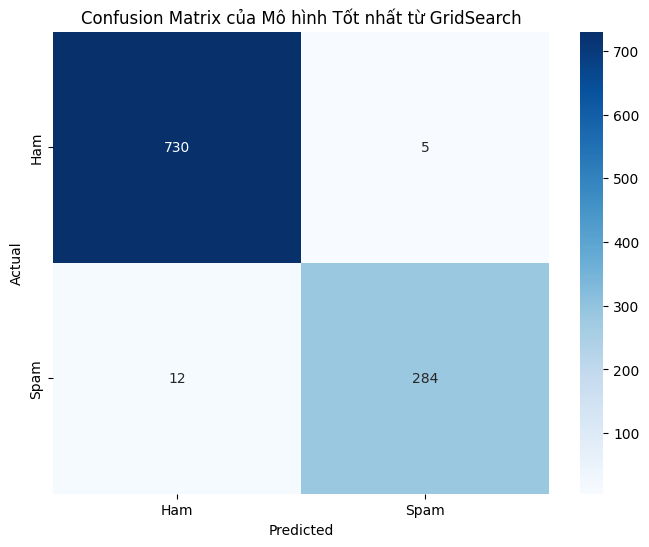

In [53]:
# 2. Confusion Matrix và Classification Report

# Dùng mô hình tốt nhất để dự đoán trên tập test
y_predicted_labels = best_model.predict(X_test_tensor)

# In kết quả
print(f"\nAccuracy: {accuracy_score(y_test, y_predicted_labels):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_predicted_labels, target_names=['Ham', 'Spam']))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix của Mô hình Tốt nhất từ GridSearch')
plt.show()


### 8. Lưu và sử dụng mô hình tốt nhất

In [54]:
# Chúng ta có thể lưu toàn bộ đối tượng này bằng joblib.
MODEL_PATH = 'checkpoints/ff_spam_classifier_model_spam_ham_dataset_cleaned_2.pth'

# Tạo thư mục nếu chưa tồn tại
os.makedirs('checkpoints', exist_ok=True)

joblib.dump(best_model, MODEL_PATH)
print(f"\nMô hình (skorch wrapper) tốt nhất đã được lưu tại: {MODEL_PATH}")


Mô hình (skorch wrapper) tốt nhất đã được lưu tại: checkpoints/ff_spam_classifier_model_spam_ham_dataset_cleaned_2.pth


In [55]:
import functools # Thêm thư viện functools

# Lưu lại hàm torch.load gốc
original_torch_load = torch.load

try:
    # Tạo một phiên bản mới của torch.load với `weights_only=False`
    # Điều này cho phép tải các tệp pickle chứa mã thực thi, chỉ an toàn khi bạn tin tưởng nguồn gốc tệp.
    torch.load = functools.partial(original_torch_load, weights_only=False)
    
    print("Đang thử tải mô hình với cài đặt tùy chỉnh...")
    # Tải mô hình
    loaded_model = joblib.load(MODEL_PATH)
    print("\nMô hình đã được tải lại và sẵn sàng để dự đoán.")

finally:
    # QUAN TRỌNG: Luôn khôi phục lại hàm torch.load gốc sau khi hoàn tất
    torch.load = original_torch_load
    print("Đã khôi phục cài đặt torch.load mặc định.")
# ----- KẾT THÚC SỬA LỖI -----

# Định nghĩa các biến cần thiết
model_name = 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(model_name)

# Hàm dự đoán sử dụng mô hình skorch
def predict_spam_skorch(message: str, embedding_model, classification_model):
    message_embedding = embedding_model.encode(message).astype(np.float32)
    message_embedding = message_embedding.reshape(1, -1)
    prediction = classification_model.predict(message_embedding)
    return "Spam" if prediction.item() == 1 else "Ham"

# Thử nghiệm với vài tin nhắn
test_messages = [
     # Spam emails
    "CONGRATULATIONS! You've won $10,000! Click here to claim your prize NOW!",
    "Urgent: Your PayPal account has been limited. Verify immediately to avoid suspension",
    "Make money from home! Earn $5000 per week working part-time!",
    "FREE iPhone 15! Limited time offer! Click here before it expires!",
    "Nigerian Prince needs your help. Guaranteed $1,000,000 return!",
    
    # Ham emails
    "Team meeting scheduled for tomorrow at 3 PM in the conference room",
    "Your order #12345 has been shipped and will arrive in 2-3 business days",
    "Monthly project status report - please review before Friday",
    "Reminder: Your dentist appointment is scheduled for next Monday",
    "Happy birthday! Hope you have a wonderful celebration today, can i go to your party tonight?"
]

for i, msg in enumerate(test_messages):
    print(f"\n--- Tin nhắn {i+1} ---")
    print(f"Nội dung: '{msg}'")
    print(f"Dự đoán: {predict_spam_skorch(msg, embedding_model, loaded_model)}")


Đang thử tải mô hình với cài đặt tùy chỉnh...

Mô hình đã được tải lại và sẵn sàng để dự đoán.
Đã khôi phục cài đặt torch.load mặc định.

--- Tin nhắn 1 ---
Nội dung: 'CONGRATULATIONS! You've won $10,000! Click here to claim your prize NOW!'
Dự đoán: Spam

--- Tin nhắn 2 ---
Nội dung: 'Urgent: Your PayPal account has been limited. Verify immediately to avoid suspension'
Dự đoán: Spam

--- Tin nhắn 3 ---
Nội dung: 'Make money from home! Earn $5000 per week working part-time!'
Dự đoán: Spam

--- Tin nhắn 4 ---
Nội dung: 'FREE iPhone 15! Limited time offer! Click here before it expires!'
Dự đoán: Spam

--- Tin nhắn 5 ---
Nội dung: 'Nigerian Prince needs your help. Guaranteed $1,000,000 return!'
Dự đoán: Spam

--- Tin nhắn 6 ---
Nội dung: 'Team meeting scheduled for tomorrow at 3 PM in the conference room'
Dự đoán: Ham

--- Tin nhắn 7 ---
Nội dung: 'Your order #12345 has been shipped and will arrive in 2-3 business days'
Dự đoán: Ham

--- Tin nhắn 8 ---
Nội dung: 'Monthly project status re

### 9. Finetune 

In [56]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 


# 1. Define a new combined model that includes the Sentence Transformer
class FullSpamModel(nn.Module):
    def __init__(self, sbert_model_name='all-MiniLM-L6-v2', 
                 classifier_hidden_dim=128, 
                 classifier_output_dim=1, 
                 classifier_dropout_rate=0.2):
        super(FullSpamModel, self).__init__()
        self.sbert = SentenceTransformer(sbert_model_name)
        
        # Get the embedding dimension from the SBERT model
        sbert_embedding_dim = self.sbert.get_sentence_embedding_dimension()
        
        # Attach the classifier head (using the same architecture as before)
        self.classifier = FeedForwardSpamClassifier(
            input_dim=sbert_embedding_dim,
            hidden_dim=classifier_hidden_dim,
            output_dim=classifier_output_dim,
            dropout_rate=classifier_dropout_rate
        )

    def forward(self, input_ids, attention_mask):
        # We need to re-package the inputs into a dictionary for the SBERT model.
        token_features = {'input_ids': input_ids, 'attention_mask': attention_mask}
        
        # Get sentence embeddings from the SBERT model.
        sbert_output = self.sbert(token_features)
        embeddings = sbert_output['sentence_embedding']
        
        # Pass the embeddings through the classifier head
        logits = self.classifier(embeddings)
        return logits

# 2. Prepare and tokenize the data (same as before)
X_text = data['cleaned_text'].values
y_labels = data['label_num'].values

# Split the RAW TEXT data
X_train_text, X_test_text, y_train_full, y_test_full = train_test_split(
    X_text, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print("Tokenizing text data for fine-tuning...")
tokenizer_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_tokenized = tokenizer_model.tokenize(X_train_text.tolist())
X_test_tokenized = tokenizer_model.tokenize(X_test_text.tolist())

X_train_tokenized

Tokenizing text data for fine-tuning...


{'input_ids': tensor([[  101,  2254,  3962,  ...,     0,     0,     0],
         [  101,  2128,  2129,  ...,     0,     0,     0],
         [  101, 10683,  5830,  ...,     0,     0,     0],
         ...,
         [  101,  2128,  3167,  ...,  2226, 14925,   102],
         [  101,  2035, 10085,  ...,     0,     0,     0],
         [  101,  2264,  5521,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [57]:

for key in X_train_tokenized:
    X_train_tokenized[key] = torch.tensor(X_train_tokenized[key])
for key in X_test_tokenized:
    X_test_tokenized[key] = torch.tensor(X_test_tokenized[key])

print("Tokenization complete.")


Tokenization complete.


/tmp/ipykernel_265605/70067095.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tokenized[key] = torch.tensor(X_train_tokenized[key])
/tmp/ipykernel_265605/70067095.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tokenized[key] = torch.tensor(X_test_tokenized[key])


In [58]:

# 3. Create a custom PyTorch Dataset
class SpamDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        self.tokenized_data = tokenized_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Create a dictionary for the features for the current index
        item = {key: val[idx] for key, val in self.tokenized_data.items()}
        # Add the label
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item
    


In [59]:
# Create Dataset and DataLoader instances
train_dataset = SpamDataset(X_train_tokenized, y_train_full)
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SpamDataset(X_test_tokenized, y_test_full)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE) # No shuffle for test set


In [60]:


# 4. Initialize model and load pre-trained classifier weights
print("\n--- Initializing Model and Loading Weights ---")
sbert_embedding_dim = tokenizer_model.get_sentence_embedding_dimension()
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

# Initialize the full model
finetune_model = FullSpamModel(
    classifier_hidden_dim=192,
    classifier_dropout_rate=0.2
).to(DEVICE)



--- Initializing Model and Loading Weights ---


In [61]:
PRETRAINED_CLASSIFIER_PATH = 'checkpoints/ff_spam_classifier_model_spam_ham_dataset_cleaned_2.pth'
original_torch_load = torch.load # Save original torch.load function

try:
    print(f"Loading pre-trained classifier from: {PRETRAINED_CLASSIFIER_PATH}")
    
    # Temporarily modify torch.load to be compatible with files saved from older torch versions
    # This is a workaround for loading pickled files that might contain code.
    # WARNING: Only use this if you trust the source of the file.
    torch.load = functools.partial(original_torch_load, weights_only=False)
    
    # Use joblib.load, which is the correct function to read the file
    skorch_model_wrapper = joblib.load(PRETRAINED_CLASSIFIER_PATH)
    
    # Get the state_dict from the inner PyTorch module
    pretrained_classifier_weights = skorch_model_wrapper.module_.state_dict()
    
    # Load these weights into the classifier part of our new model
    finetune_model.classifier.load_state_dict(pretrained_classifier_weights)
    print("Successfully loaded pre-trained weights for the classifier head.")
except FileNotFoundError:
    print(f"Warning: Pre-trained classifier not found at {PRETRAINED_CLASSIFIER_PATH}. Training classifier from scratch.")
except Exception as e:
    print(f"An error occurred while loading weights: {e}. Training classifier from scratch.")
finally:
    # IMPORTANT: Always restore the original torch.load function
    torch.load = original_torch_load
    print("Restored default torch.load behavior.")

Loading pre-trained classifier from: checkpoints/ff_spam_classifier_model_spam_ham_dataset_cleaned_2.pth
Successfully loaded pre-trained weights for the classifier head.
Restored default torch.load behavior.


In [62]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# 5. Set up Optimizer, Loss Function, and Training Loop
LEARNING_RATE = 1e-5
NUM_EPOCHS = 10

# Use AdamW optimizer, standard for Transformer models
optimizer = torch.optim.AdamW(finetune_model.parameters(), lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
# Use the same loss function as before, with class weighting
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(DEVICE))



--- Starting Training ---


New best validation loss: 0.3957, saving model state...
Epoch 1/10 -> Train Loss: 0.0370 | Validation Loss: 0.3957


New best validation loss: 0.1584, saving model state...
Epoch 2/10 -> Train Loss: 0.0359 | Validation Loss: 0.1584


New best validation loss: 0.1558, saving model state...
Epoch 3/10 -> Train Loss: 0.0608 | Validation Loss: 0.1558


Epoch 4/10 -> Train Loss: 0.0157 | Validation Loss: 0.1918


Epoch 5/10 -> Train Loss: 0.0091 | Validation Loss: 0.1705


Epoch 6/10 -> Train Loss: 0.0061 | Validation Loss: 0.2353


Epoch 7/10 -> Train Loss: 0.0050 | Validation Loss: 0.1912


Epoch 8/10 -> Train Loss: 0.0066 | Validation Loss: 0.1751


Epoch 9/10 -> Train Loss: 0.0095 | Validation Loss: 0.1609


Epoch 10/10 -> Train Loss: 0.0048 | Validation Loss: 0.1673

Training complete.


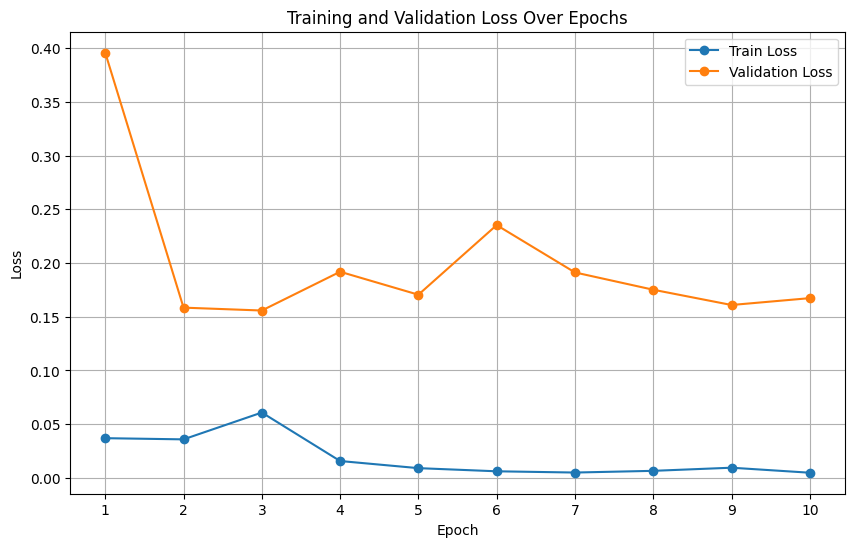

Finetuned model saved at: checkpoints/finetuned_spam_classifier_model_2.pth


In [63]:
print("\n--- Starting Training ---")

history = {'train_loss': [], 'val_loss': []}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    # --- TRAINING LOOP ---
    finetune_model.train() # Set the model to training mode
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = finetune_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # --- VALIDATION LOOP ---
    finetune_model.eval() # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad(): # Disable gradient calculations for validation
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]", leave=False):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE).unsqueeze(1)
            
            outputs = finetune_model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        # Save the best model state
        best_finetuned_model = finetune_model
        print(f"New best validation loss: {avg_val_loss:.4f}, saving model state...")

    scheduler.step()

    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

print("\nTraining complete.")

# 6. Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(NUM_EPOCHS), [i+1 for i in range(NUM_EPOCHS)]) # Ensure x-axis shows epoch numbers
plt.legend()
plt.grid(True)
plt.show()

# save finetuned model
FINETUNED_MODEL_PATH = 'checkpoints/finetuned_spam_classifier_model_2.pth'
# Tạo thư mục nếu chưa tồn tại
os.makedirs('checkpoints', exist_ok=True)
torch.save(best_finetuned_model.state_dict(), FINETUNED_MODEL_PATH)
print(f"Finetuned model saved at: {FINETUNED_MODEL_PATH}")


--- Evaluating Final Model on Test Set ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.75it/s]



Accuracy on Test Set: 0.9893

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       735
        Spam       0.98      0.98      0.98       296

    accuracy                           0.99      1031
   macro avg       0.99      0.99      0.99      1031
weighted avg       0.99      0.99      0.99      1031



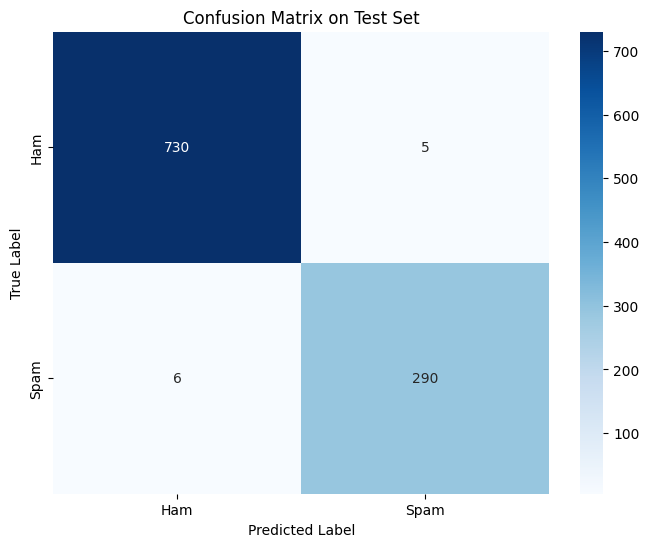

In [64]:
print("\n--- Evaluating Final Model on Test Set ---")
best_finetuned_model.eval() # Set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad(): # No need to calculate gradients for evaluation
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'] # Keep labels on CPU for easy collection
        
        # Get model outputs (logits)
        outputs = best_finetuned_model(input_ids, attention_mask)
        
        # Convert logits to probabilities using sigmoid, then to predictions (0 or 1)
        # Move outputs to CPU for numpy conversion
        preds = torch.sigmoid(outputs).cpu() > 0.5
        
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print results
print(f"\nAccuracy on Test Set: {accuracy_score(all_labels, all_preds):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Ham', 'Spam']))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()
